In [43]:
import warnings
warnings.filterwarnings('ignore')

/Users/elishasiddiqui/.conda/envs/qutip_clone_test/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [44]:
%matplotlib inline
import numpy as np
import qiskit
from qiskit import QuantumCircuit, transpile, Aer, IBMQ, QuantumRegister
from qiskit.tools.jupyter import *
from qiskit.visualization import *
from ibm_quantum_widgets import *
from qiskit import pulse,schedule
from qiskit.pulse import Schedule

In [45]:
TOKEN = '023f373dc54c121ed029051e578c1c639af5bb83bbd20f56acdbbdfae0faf3782ff72329750d32853370939170a2ddf7785f1f31550186921b0351abf7cdb128'

In [46]:
IBMQ.save_account(TOKEN)
IBMQ.load_account()

configrc.store_credentials:WARNING:2021-06-05 11:40:55,365: Credentials already present. Set overwrite=True to overwrite.
ibmqfactory.load_account:WARNING:2021-06-05 11:40:55,834: Credentials are already in use. The existing account in the session will be replaced.


<AccountProvider for IBMQ(hub='ibm-q', group='open', project='main')>

In [47]:
import matplotlib.pyplot as plt
import datetime
from qutip import Qobj, identity, sigmax, sigmay, sigmaz, sigmam, tensor
from qutip.superoperator import liouvillian, sprepost
from qutip.qip import hadamard_transform
from qutip.qip.operations.gates import rx,sqrtnot
import qutip.logging_utils as logging
logger = logging.get_logger()
#Set this to None or logging.WARN for 'quiet' execution
log_level = logging.INFO
#QuTiP control modules
import qutip.control.pulseoptim as cpo

importing the Hamiltonian parameters from qiskit

In [48]:
provider =IBMQ.get_provider(hub='ibm-q-bnl', group='bnl-non-c2qa-pro', project='physics-guided-o')

In [49]:
backend = provider.get_backend('ibmq_bogota')

In [50]:
backend_defaults = backend.defaults(backend)
backend_config = backend.configuration()
assert backend_config.open_pulse, "Backend doesn't support Pulse"

In [51]:
props = backend.properties()

In [ ]:
props.to_dict()

In [52]:
# unit conversion factors -> all backend properties returned in SI (Hz, sec, etc)
GHz = 1.0e9 # Gigahertz
MHz = 1.0e6 # Megahertz
us = 1.0e-6 # Microseconds
ns = 1.0e-9 # Nanoseconds


In [53]:
qubit = 2

In [54]:
w0 = backend_defaults.qubit_freq_est[qubit]/GHz

In [ ]:
rx(np.pi/2)

In [55]:
#The Hamiltoninan model
Sx = sigmax()
Sy = sigmay()
Sz = sigmaz()
Sm = sigmam()
Si = identity(2)

#sx_gate = tensor(sqrtnot(),Si)
had = tensor(hadamard_transform(1),Si)
U_0 = tensor(Si,Si)

In [56]:
#H0 = 0.5*w0*Sz
H0 = (0.5*tensor(Sz,Si)*w0)+(0.5*0.0013)*(tensor(Sx,Sx)+tensor(Sy,Sy))
Hc = [tensor(Sx,Si),tensor(Sy,Si),tensor(Sz,Si)]
#Hc = [tensor(Sx,Si),tensor(Si,Sx)]

In [57]:
t1 = props.t1(qubit)
t2 = props.t2(qubit)

gamma1=(1/t1)/GHz
gamma2=(1/t2)/GHz

In [58]:
L0 = liouvillian(H0,[np.sqrt(gamma1)*tensor(Sm,Si)])

In [59]:
#sigma X control
LC_x = liouvillian(Hc[0])
LC_y = liouvillian(Hc[1])
LC_z = liouvillian(Hc[2])

#Drift
drift = L0
#Controls - different combinations can be tried
ctrls = [LC_x, LC_y, LC_z]
# Number of ctrls
n_ctrls = len(ctrls)

# start point for the map evolution
E0 = sprepost(U_0, U_0)

# target for map evolution
#E_targ = sprepost(sx_gate, sx_gate)
E_targ = sprepost(had,had) 

In [19]:
x=backend_defaults.to_dict()

i=0
for gate in x['cmd_def']:

    print(gate['name'],i)
    i=i+1

cx 0
cx 1
cx 2
cx 3
cx 4
cx 5
cx 6
cx 7
id 8
id 9
id 10
id 11
id 12
measure 13
measure 14
measure 15
measure 16
measure 17
measure 18
rz 19
rz 20
rz 21
rz 22
rz 23
sx 24
sx 25
sx 26
sx 27
sx 28
u1 29
u1 30
u1 31
u1 32
u1 33
u2 34
u2 35
u2 36
u2 37
u2 38
u3 39
u3 40
u3 41
u3 42
u3 43
x 44
x 45
x 46
x 47
x 48


/Users/elishasiddiqui/.conda/envs/qutip_clone_test/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [20]:
for i in x['cmd_def'][24]['sequence']:
    print(i)

{'name': 'parametric_pulse', 't0': 0, 'ch': 'd0', 'label': 'X90p_d0', 'pulse_shape': 'drag', 'parameters': {'amp': (0.09494988273580766+0.001021165184704556j), 'beta': -1.1460375211506877, 'duration': 160, 'sigma': 40}}


/Users/elishasiddiqui/.conda/envs/qutip_clone_test/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [60]:
# Time allowed for the evolution
evo_time = 160
# Number of time slots
n_ts = int(float(evo_time/0.222))

#beta
#beta = -1.1526
#scaling = 0.09484
# Fidelity error target
fid_err_targ = 1e-3
# Maximum iterations for the optisation algorithm
max_iter = 1000
# Maximum (elapsed) time allowed in seconds
max_wall_time = 300
# Minimum gradient (sum of gradients squared)
# as this tends to 0 -> local minima has been found
min_grad = 1e-20
p_type = 'SINE'
#Run optimization
result = cpo.optimize_pulse(drift, ctrls, E0, E_targ, n_ts, evo_time,amp_lbound=0, amp_ubound=1, 
                fid_err_targ=fid_err_targ, min_grad=min_grad, 
                max_iter=max_iter, max_wall_time=max_wall_time, 
                out_file_ext=None, init_pulse_type=p_type, 
                log_level=log_level, gen_stats=True)
#result=cpo.optimize_pulse_unitary(H0, Hc, U_0, sx_gate, n_ts, evo_time,
#                             amp_lbound=0,amp_ubound=1,
#                fid_err_targ=fid_err_targ, min_grad=min_grad, 
#                max_iter=max_iter, max_wall_time=max_wall_time, 
#                out_file_ext=None, init_pulse_type=p_type, 
#                log_level=log_level, gen_stats=True)
result.stats.report()
print("Final evolution\n{}\n".format(result.evo_full_final))
print("********* Summary *****************")
print("Initial fidelity error {}".format(result.initial_fid_err))
print("Final fidelity error {}".format(result.fid_err))
print("Final gradient normal {}".format(result.grad_norm_final))
print("Terminated due to {}".format(result.termination_reason))
print("Number of iterations {}".format(result.num_iter))
print("Completed in {} HH:MM:SS.US".format(datetime.timedelta(seconds=result.wall_time)))

INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching False
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift dynamics generator:
Quantum object: dims = [[[2, 2], [2, 2]], [[2, 2], [2, 2]]], shape = (16, 16), type = super, isherm = False
Qobj data =
[[-6.96342943e-06+0.00000000e+00j  0.00000000e+00+0.00000000e+00j
   0.00000000e+00+0.00000000e+00j  0.00000000e+00+0.00000000e+00j
   0.00000000e+00+0.00000000e+00j  0.00000000e+00+0.00000000e+00j
   0.00000000e+00+0.00000000e+00j  0.00000000e+00+0.00000000e+00j
   0.00000000e+00+0.00000000e+00j  0.00000000e+00+0.00000000e+00j
   0.00000000e+00+0.00000000e+00j  0.00000000e+00+0.00000000e

INFO:qutip.control.optimizer:Optimising pulse(s) using GRAPE with 'fmin_l_bfgs_b' method



------------------------------------
---- Control optimisation stats ----
**** Timings (HH:MM:SS.US) ****
Total wall time elapsed during optimisation: 0:00:03.077251
Wall time computing Hamiltonians: 0:00:00.046773 (1.52%)
Wall time computing propagators: 0:00:02.437053 (79.20%)
Wall time computing forward propagation: 0:00:00.015180 (0.49%)
Wall time computing onward propagation: 0:00:00.015281 (0.50%)
Wall time computing gradient: 0:00:00.237173 (7.71%)

**** Iterations and function calls ****
Number of iterations: 2
Number of fidelity function calls: 6
Number of times fidelity is computed: 6
Number of gradient function calls: 5
Number of times gradients are computed: 5
Number of times timeslot evolution is recomputed: 6

**** Control amplitudes ****
Number of control amplitude updates: 5
Mean number of updates per iteration: 2.5
Number of timeslot values changed: 3587
Mean number of timeslot changes per update: 717.4
Number of amplitude values changed: 9956
Mean number of amplitude

# Qiskit part

In [61]:
x = result.final_amps.T[0]
#x1 = result.final_amps.T[1]
y = result.final_amps.T[1]
z = result.final_amps.T[2]

In [62]:
from qiskit.pulse import (Acquire, AcquireChannel, ControlChannel, Delay, 
                          DriveChannel, MeasureChannel, MemorySlot, Play,
                          Schedule, ShiftPhase, Waveform,build)

In [63]:
def get_closest_multiple_of_16(num):
    return int(num + 8 ) - (int(num + 8 ) % 16)    

In [64]:
gatename='h'

In [65]:
Ncx = get_closest_multiple_of_16(len(x))
#Ncx1 = get_closest_multiple_of_16(len(x1))
Ncy = get_closest_multiple_of_16(len(y))
Ncz = get_closest_multiple_of_16(len(z))

padded_pulsex = [0 for i in range(Ncx+16)]
#padded_pulsex1 = [0 for i in range(Ncx1+16)]
padded_pulsey = [0 for i in range(Ncy+16)]
padded_pulsez = [0 for i in range(Ncz+16)]

padded_pulsey[0:len(y)] = y
padded_pulsex[0:len(x)] = x
#padded_pulsex1[0:len(x1)] = x1
padded_pulsez[0:len(z)] = z

with build(name='h') as h_q0:
    pulse.play(Waveform(padded_pulsex),DriveChannel(qubit))
    #pulse.play(Waveform(padded_pulsex1),DriveChannel(qubit+1))
    pulse.play(Waveform(padded_pulsey),DriveChannel(qubit))
    pulse.play(Waveform(padded_pulsez),DriveChannel(qubit))
    

In [66]:
cals = backend.defaults().instruction_schedule_map
basis_gates = backend_config.basis_gates
basis_gates += ['my_1q']
cals.add('my_1q',(qubit),h_q0)

In [67]:
from qiskit.circuit import Gate
h1 = Gate('my_1q',num_qubits=1,params=[])


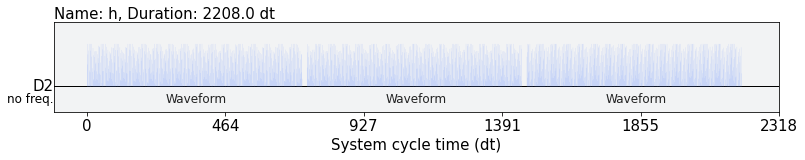

In [68]:
cals.get('my_1q',[qubit]).draw()

In [69]:
q = QuantumRegister(backend_config.n_qubits)
circ = QuantumCircuit(backend_config.n_qubits)
circ.append(h1,[qubit])

In [70]:
import qiskit.quantum_info as qi
# Tomography functions
from qiskit.ignis.verification.tomography import state_tomography_circuits, StateTomographyFitter
from qiskit.ignis.verification.tomography import process_tomography_circuits, ProcessTomographyFitter
from qiskit.ignis.verification.tomography import gateset_tomography_circuits, GatesetTomographyFitter
import qiskit.ignis.mitigation.measurement as mc

# Auxiliary methods
from qiskit.quantum_info import Choi, Kraus
from qiskit.extensions import HGate, XGate

In [71]:
target_unitary = qi.Operator(HGate())
qpt_circs = process_tomography_circuits(circ,[qubit])
qpt_tcircs = transpile(qpt_circs,backend,basis_gates)
from qiskit.pulse.reschedule import align_measures
from qiskit.qobj import PulseQobj
qpt_schedules = align_measures(schedule(qpt_tcircs,backend=backend,inst_map=cals),inst_map=cals)

In [72]:
from qiskit import assemble
qobj = assemble(qpt_schedules,backend=backend,meas_level=2,shots=500)

In [73]:
job_qpt = backend.run(qobj)
print(job_qpt.job_id())

60bba95b544b80429dd40bae


In [74]:
qpt_tomo = ProcessTomographyFitter(job_qpt.result(), qpt_circs)
qpt_tomo.data

{(('Zp',), ('X',)): {'0': 407, '1': 93},
 (('Zp',), ('Y',)): {'0': 147, '1': 353},
 (('Zp',), ('Z',)): {'0': 165, '1': 335},
 (('Zm',), ('X',)): {'0': 415, '1': 85},
 (('Zm',), ('Y',)): {'0': 329, '1': 171},
 (('Zm',), ('Z',)): {'0': 269, '1': 231},
 (('Xp',), ('X',)): {'0': 466, '1': 34},
 (('Xp',), ('Y',)): {'0': 265, '1': 235},
 (('Xp',), ('Z',)): {'0': 234, '1': 266},
 (('Yp',), ('X',)): {'0': 437, '1': 63},
 (('Yp',), ('Y',)): {'0': 194, '1': 306},
 (('Yp',), ('Z',)): {'0': 335, '1': 165}}

In [75]:
choi_fit_lstsq = qpt_tomo.fit(method='lstsq')
print('Average gate fidelity: F = {:.5f}'.format(qi.average_gate_fidelity(choi_fit_lstsq, target=target_unitary)))

Average gate fidelity: F = 0.53800


# Error Mitigation

In [76]:
# Import measurement calibration functions
from qiskit.ignis.mitigation.measurement import (complete_meas_cal, tensored_meas_cal,
                                                 CompleteMeasFitter, TensoredMeasFitter)

In [77]:
qr = QuantumRegister(backend_config.n_qubits)
qubit_list=[qubit]
meas_calibs, state_labels = complete_meas_cal(qubit_list=qubit_list, qr=qr, circlabel='mcal')

In [78]:
t_qc = transpile(meas_calibs,backend)

In [79]:
job_mt = qiskit.execute(meas_calibs, backend=backend, shots=1000)
print(job_mt.job_id())
cal_results = job_mt.result()

60bbace8a8e98d75c1bcc4a5


In [80]:
# The calibration matrix without noise is the identity matrix
meas_fitter = CompleteMeasFitter(cal_results, state_labels, circlabel='mcal')
print(meas_fitter.cal_matrix)

[[0.978 0.033]
 [0.022 0.967]]


In [81]:
qpt_result1=meas_fitter.filter.apply(job_qpt.result())

In [82]:
qpt_tomo = ProcessTomographyFitter(qpt_result1, qpt_circs)
qpt_tomo.data
choi_fit_lstsq = qpt_tomo.fit(method='lstsq')
print('Average gate fidelity: F = {:.5f}'.format(qi.average_gate_fidelity(choi_fit_lstsq, target=target_unitary)))

Average gate fidelity: F = 0.53978


# Implementation in circuit

In [39]:
qr = QuantumRegister(qubit+1)
cr = qiskit.ClassicalRegister(qubit+1)
circ1 = QuantumCircuit(qr,cr)
circ1.append(h1,[qubit])
#circ.rz(-np.pi/4,qubit)
circ1.measure(qr[qubit],cr[0])
circ1.draw()

/Users/elishasiddiqui/.conda/envs/qutip_clone_test/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


┌───────┐┌─┐
q253_0: ┤ my_1q ├┤M├
        └───────┘└╥┘
  c1: 1/══════════╩═
                  0

In [40]:
dt = backend.configuration().dt
from qiskit import transpile, schedule as build_schedule
tcirc = transpile(circ1,backend,basis_gates)
schedule1 = schedule(tcirc, backend, inst_map=cals)

/Users/elishasiddiqui/.conda/envs/qutip_clone_test/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/Users/elishasiddiqui/.conda/envs/qutip_clone_test/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


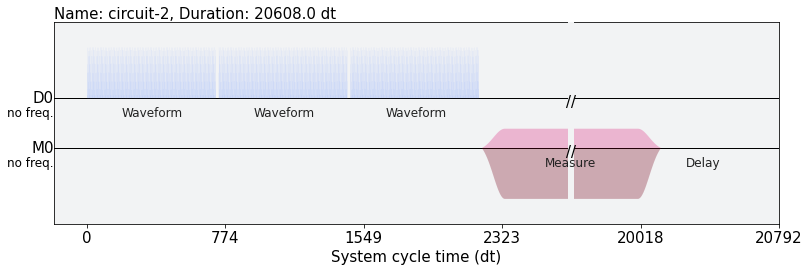

In [33]:
schedule1.draw()

In [41]:
from qiskit import execute
from qiskit.tools.monitor import job_monitor

/Users/elishasiddiqui/.conda/envs/qutip_clone_test/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [42]:
h_job = execute([schedule1],backend,meas_level=2,shots=1048).result()
print(h_job.job_id)

/Users/elishasiddiqui/.conda/envs/qutip_clone_test/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/Users/elishasiddiqui/.conda/envs/qutip_clone_test/lib/python3.8/site-packages/ipywidgets/widgets/widget_layout.py:84: DeprecationWarning: Layout properties overflow_x and overflow_y have been deprecated and will be dropped in a future release. Please use the overflow shorthand property instead
  warnings.warn("Layout properties overflow_x and overflow_y have been deprecated and will be dropped in a future release. Please use the overflow shorthand property instead", DeprecationWarning)


60b9143142c6a9209df0fe1b


In [43]:
# Results without mitigation
raw_counts = h_job.get_counts()



/Users/elishasiddiqui/.conda/envs/qutip_clone_test/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/Users/elishasiddiqui/.conda/envs/qutip_clone_test/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


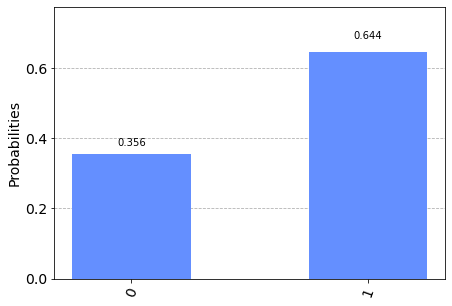

In [44]:
from qiskit.result.utils import marginal_counts
from qiskit.visualization import plot_histogram
plot_histogram(marginal_counts(raw_counts, [0,0], format_marginal=True))

/Users/elishasiddiqui/.conda/envs/qutip_clone_test/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


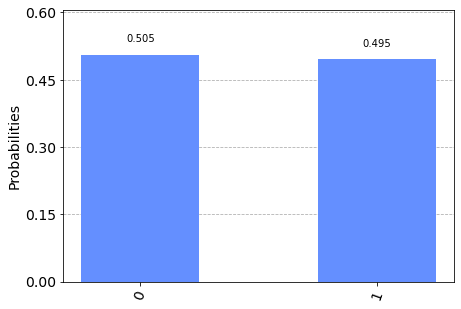

In [38]:
from qiskit.result.utils import marginal_counts
from qiskit.visualization import plot_histogram
plot_histogram(marginal_counts(raw_counts, [0,0], format_marginal=True))

In [39]:
# Get the filter object
#build a fitter from the subset
#meas_fitter_sub = meas_fitter.subset_fitter(qubit_sublist=[1])
# Get the filter object
meas_filter = meas_fitter.filter

# Results with mitigation
mitigated_results = meas_filter.apply(h_job)
mitigated_counts = mitigated_results.get_counts(0)

/Users/elishasiddiqui/.conda/envs/qutip_clone_test/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/Users/elishasiddiqui/.conda/envs/qutip_clone_test/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


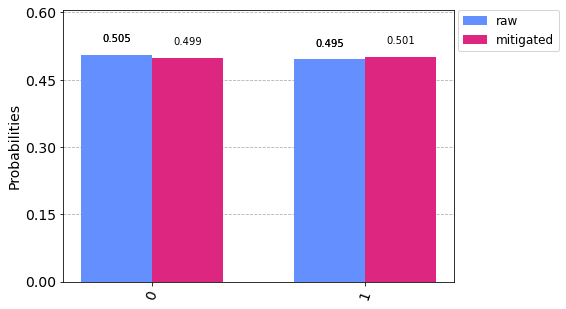

In [40]:
from qiskit.result.utils import marginal_counts
from qiskit.visualization import plot_histogram
plot_histogram([marginal_counts(raw_counts,[0,0]), marginal_counts(mitigated_counts,[0,0])], legend=['raw', 'mitigated'])

In [41]:
qr = QuantumRegister(qubit+1)
cr = qiskit.ClassicalRegister(qubit+1)
circ1 = QuantumCircuit(qr,cr)
circ1.h(qr[qubit])

circ1.measure(qr[qubit],cr[0])
circ1.draw()

/Users/elishasiddiqui/.conda/envs/qutip_clone_test/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


┌───┐┌─┐
q48_0: ┤ H ├┤M├
       └───┘└╥┘
 c2: 1/══════╩═
             0

In [42]:
job = qiskit.execute([circ1], backend=backend, shots=1048)#, noise_model=noise_model)
results = job.result()

/Users/elishasiddiqui/.conda/envs/qutip_clone_test/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/Users/elishasiddiqui/.conda/envs/qutip_clone_test/lib/python3.8/site-packages/ipywidgets/widgets/widget_layout.py:84: DeprecationWarning: Layout properties overflow_x and overflow_y have been deprecated and will be dropped in a future release. Please use the overflow shorthand property instead
  warnings.warn("Layout properties overflow_x and overflow_y have been deprecated and will be dropped in a future release. Please use the overflow shorthand property instead", DeprecationWarning)


In [43]:
default = results.get_counts()

/Users/elishasiddiqui/.conda/envs/qutip_clone_test/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/Users/elishasiddiqui/.conda/envs/qutip_clone_test/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


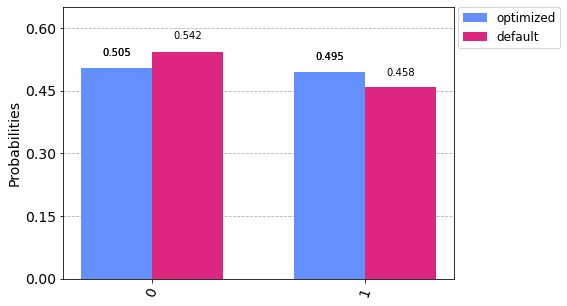

In [44]:
plot_histogram([marginal_counts(raw_counts,[0,0]), marginal_counts(default,[0,0])], legend=['optimized', 'default'])

In [ ]:
import qiskit
qiskit.__qiskit_version__

In [48]:
basis_gates

['id', 'rz', 'sx', 'x', 'cx', 'reset', 'my_1q']

Randomized BEnchmarking

In [38]:
from qiskit.ignis.verification.randomized_benchmarking import randomized_benchmarking_seq
import qiskit.ignis.verification.randomized_benchmarking as rb

/Users/elishasiddiqui/.conda/envs/qutip_clone_test/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [39]:
rb_inst_map = backend_defaults.instruction_schedule_map

/Users/elishasiddiqui/.conda/envs/qutip_clone_test/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [40]:
rb_inst_map.add('my_1q',(qubit),schedule=schedule1)

/Users/elishasiddiqui/.conda/envs/qutip_clone_test/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [42]:
shots = 1024
n_seeds = 5
n_cliffs = np.arange(1, 200, 20)
# create 1Q RB sequences
rb_patterns_1q = [[qubit]]
xdata_1q = np.array([n_cliffs, n_cliffs])

rb_1q_circs_seeds, _ = rb.randomized_benchmarking_seq(length_vector=n_cliffs,
                                                          nseeds=n_seeds,
                                                          rb_pattern=rb_patterns_1q)

/Users/elishasiddiqui/.conda/envs/qutip_clone_test/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [43]:
back_defaults = backend.defaults()
rb_inst_map = back_defaults.instruction_schedule_map
rb_inst_map.add(gatename,qubits=(qubit),schedule=schedule1)

/Users/elishasiddiqui/.conda/envs/qutip_clone_test/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [44]:
pulse_qobjs = []
transpiled_circs = []
for rb_seed_circ in rb_1q_circs_seeds:
        # transpile
        rb_seed_circ_transpiled = qiskit.transpile(rb_seed_circ, backend, optimization_level=0)
        transpiled_circs.append(rb_seed_circ_transpiled)
        # schedule
        rb_seed_sched = qiskit.schedule(rb_seed_circ_transpiled, backend, inst_map=rb_inst_map)
        # create pulse qobj
        pulse_qobjs.append(qiskit.assemble(rb_seed_sched, backend, meas_level=2, shots=shots))
    

/Users/elishasiddiqui/.conda/envs/qutip_clone_test/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [45]:
jobs = []
for qobj in pulse_qobjs:
    job = backend.run(qobj)
    jobs.append(job)
    
job_results = []
for job in jobs:
    job_results.append(job.result())

/Users/elishasiddiqui/.conda/envs/qutip_clone_test/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
<ipython-input-45-197d1df82457>:3: DeprecationWarning: Passing a Qobj to Backend.run is deprecated and will be removed in a future release. Please pass in circuits or pulse schedules instead.
  job = backend.run(qobj)
/Users/elishasiddiqui/.conda/envs/qutip_clone_test/lib/python3.8/site-packages/ipywidgets/widgets/widget_layout.py:84: DeprecationWarning: Layout properties overflow_x and overflow_y have been deprecated and will be dropped in a future release. Please use the overflow shorthand property instead
  warnings.warn("Layout properties overflow_x and overflow_y have been deprecated and will b

In [46]:
rb_1q_fit = rb.fitters.RBFitter(job_results, cliff_lengths=xdata_1q, rb_pattern=rb_patterns_1q)

/Users/elishasiddiqui/.conda/envs/qutip_clone_test/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/Users/elishasiddiqui/.conda/envs/qutip_clone_test/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


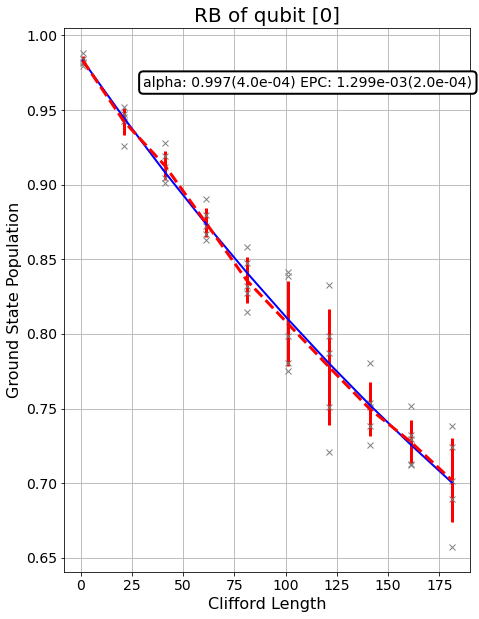

In [47]:
plt.figure(figsize=(16, 10))

for ii in range(len(rb_patterns_1q)):
    ax = plt.subplot(len(rb_patterns_1q), 2, ii+1)
    rb_1q_fit.plot_rb_data(pattern_index=ii, ax=ax, show_plt=False)
    ax.set_title('RB of qubit %s' % rb_patterns_1q[ii], fontsize=20)

plt.show()

In [48]:
# count gate per Clifford
gpc = rb.rb_utils.gates_per_clifford(
    transpiled_circuits_list=transpiled_circs,
    clifford_lengths=xdata_1q,
    basis=basis_gates,
    qubits=rb_patterns_1q[0]
)
gpc

/Users/elishasiddiqui/.conda/envs/qutip_clone_test/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


{0: {'id': 0.0,
  'rz': 3.9678260869565216,
  'sx': 2.961086956521739,
  'x': 0.12434782608695652,
  'cx': 0.0,
  'reset': 0.0,
  'my_1q': 0.0}}

In [49]:
basis_gates

/Users/elishasiddiqui/.conda/envs/qutip_clone_test/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


['id', 'rz', 'sx', 'x', 'cx', 'reset', 'my_1q']

In [50]:
gates_per_cliff = rb.rb_utils.gates_per_clifford(transpiled_circs,xdata_1q[0],basis_gates,rb_patterns_1q[0])
for basis_gate in basis_gates:
    print("Number of %s gates per Clifford: %f "%(basis_gate ,
                                                  np.mean([gates_per_cliff[0][basis_gate]
                                                           ])))

Number of id gates per Clifford: 0.000000 
Number of rz gates per Clifford: 7.935652 
Number of sx gates per Clifford: 5.922174 
Number of x gates per Clifford: 0.248696 
Number of cx gates per Clifford: 0.000000 
Number of reset gates per Clifford: 0.000000 
Number of my_1q gates per Clifford: 0.000000 


/Users/elishasiddiqui/.conda/envs/qutip_clone_test/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [52]:
epg_q0 = rb.rb_utils.calculate_1q_epg(gates_per_cliff,rb_1q_fit.fit[rb_patterns_1q[0][0]]['epc'],qubit=0)

/Users/elishasiddiqui/.conda/envs/qutip_clone_test/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


QiskitError: 'Invalid basis set is given. Use `u1`, `u2`, `u3` for basis gates.'

In [63]:
shots = 500
result_list = []
transpile_list = []
import time
for rb_seed,rb_circ_seed in enumerate(rb_circs):
    print('Compiling seed %d'%rb_seed)
    rb_circ_transpile = transpile(rb_circ_seed, basis_gates=basis_gates)
    print('Simulating seed %d'%rb_seed)
    rb_seed_sched = qiskit.schedule(rb_circ_transpile, backend, inst_map=rb_inst_map)
    job = execute(rb_seed_sched,shots=shots, backend=backend)
    result_list.append(job.result())
    transpile_list.append(rb_circ_transpile)    
print("Finished Simulating")

/Users/elishasiddiqui/.conda/envs/qutip_clone_test/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Compiling seed 0
Simulating seed 0


/Users/elishasiddiqui/.conda/envs/qutip_clone_test/lib/python3.8/site-packages/ipywidgets/widgets/widget_layout.py:84: DeprecationWarning: Layout properties overflow_x and overflow_y have been deprecated and will be dropped in a future release. Please use the overflow shorthand property instead
  warnings.warn("Layout properties overflow_x and overflow_y have been deprecated and will be dropped in a future release. Please use the overflow shorthand property instead", DeprecationWarning)


Compiling seed 1
Simulating seed 1


/Users/elishasiddiqui/.conda/envs/qutip_clone_test/lib/python3.8/site-packages/ipywidgets/widgets/widget_layout.py:84: DeprecationWarning: Layout properties overflow_x and overflow_y have been deprecated and will be dropped in a future release. Please use the overflow shorthand property instead
  warnings.warn("Layout properties overflow_x and overflow_y have been deprecated and will be dropped in a future release. Please use the overflow shorthand property instead", DeprecationWarning)


Compiling seed 2
Simulating seed 2


/Users/elishasiddiqui/.conda/envs/qutip_clone_test/lib/python3.8/site-packages/ipywidgets/widgets/widget_layout.py:84: DeprecationWarning: Layout properties overflow_x and overflow_y have been deprecated and will be dropped in a future release. Please use the overflow shorthand property instead
  warnings.warn("Layout properties overflow_x and overflow_y have been deprecated and will be dropped in a future release. Please use the overflow shorthand property instead", DeprecationWarning)


Finished Simulating


In [64]:
rbfit = rb.fitters.RBFitter(result_list, xdata, rb_opts['rb_pattern'])

/Users/elishasiddiqui/.conda/envs/qutip_clone_test/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


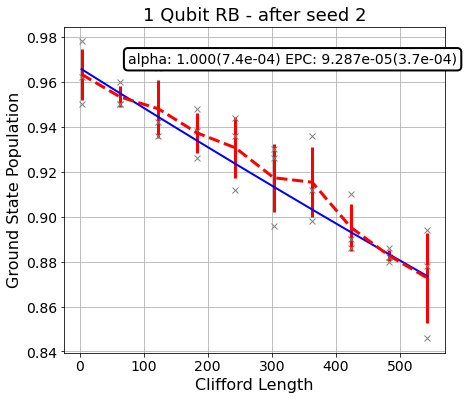

In [65]:
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from IPython import display

for seed_num, data in enumerate(result_list):#range(1,len(result_list)):  
    plt.figure(figsize=(15, 6))
    axis = [plt.subplot(1, 2, 1)]
    
    # Add another seed to the data
    rbfit.add_data([data])
    
    for i in range(1):
        pattern_ind = i

        # Plot the essence by calling plot_rb_data
        rbfit.plot_rb_data(pattern_ind, ax=axis[i], add_label=True, show_plt=False)

        # Add title and label
        axis[i].set_title('%d Qubit RB - after seed %d'%(len(rb_opts['rb_pattern'][i]), seed_num), fontsize=18)
        
    # Display
    display.display(plt.gcf())
    
    # Clear display after each seed and close
    display.clear_output(wait=True)
    time.sleep(1.0)
    plt.close()

In [66]:
basis_gates = backend_config.basis_gates
gates_per_cliff = rb.rb_utils.gates_per_clifford(transpile_list,xdata[0],basis_gates,rb_opts['rb_pattern'][0])
for basis_gate in basis_gates:
    print("Number of %s gates per Clifford: %f "%(basis_gate ,
                                                  np.mean([gates_per_cliff[0][basis_gate]
                                                           ])))

Number of id gates per Clifford: 0.000000 
Number of rz gates per Clifford: 1.364842 
Number of sx gates per Clifford: 0.931873 
Number of x gates per Clifford: 0.034793 
Number of cx gates per Clifford: 0.000000 
Number of reset gates per Clifford: 0.000000 
Number of my_1q gates per Clifford: 0.000000 


/Users/elishasiddiqui/.conda/envs/qutip_clone_test/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [67]:
#epgs_0q = {'rz':0,'sx':props.gate_error('sx',0),'x':props.gate_error('x',0)}
#epgs_1q = {'rz':0,'sx':props.gate_error('sx',1),'x':props.gate_error('x',1)}
epgs_q = {'rz':qubit,'sx':props.gate_error('sx',qubit),'x':props.gate_error('x',qubit),'my_1q':props.gate_error('sx',qubit)}
#epg_2q = props.gate_error('cx',[0,1])
epc = rb.rb_utils.calculate_1q_epc(
    gate_per_cliff=gates_per_cliff,
    epg_1q=epgs_q,
    qubit=0)



# Calculate the predicted epc
print("Predicted 1Q Error per Clifford: %e"%epc)

Predicted 1Q Error per Clifford: 1.911746e-04


/Users/elishasiddiqui/.conda/envs/qutip_clone_test/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
